# Мария Студеникина СТФИ-122
## Вариант 2

In [1]:
# Импорт библиотек для проведения расчетов
import pandas as pd
import numpy as np
#import matplotlib as plt
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox
import seaborn as sns 
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import KBinsDiscretizer

In [2]:
# Загружаем данные из файла
df = pd.read_csv("/Users/manya/Desktop/data/dz_3/train.csv")
# Пример данных
df

,TargetB,ID,TargetD,GiftCnt36,GiftCntAll,GiftCntCard36,GiftCntCardAll,GiftAvgLast,GiftAvg36,GiftAvgAll,...,PromCntCard36,PromCntCardAll,StatusCat96NK,StatusCatStarAll,DemAge,DemGender,DemHomeOwner,DemMedHomeValue,DemPctVeterans,DemMedIncome
0,0,14974,NaN,2,4,1,3,$17.00,$13.50,$9.25,...,8,13,A,0,NaN,F,U,$0,0,NaN
1,0,6294,NaN,1,8,0,3,$20.00,$20.00,$15.88,...,5,24,A,0,67.0,F,U,"$186,800",85,NaN
2,1,46110,$4.00,6,41,3,20,$6.00,$5.17,$3.73,...,11,22,S,1,NaN,M,U,"$87,600",36,"$38,750"
3,1,185937,$10.00,3,12,3,8,$10.00,$8.67,$8.50,...,6,16,E,1,NaN,M,U,"$139,200",27,"$38,942"
4,0,29637,NaN,1,1,1,1,$20.00,$20.00,$20.00,...,7,6,F,0,53.0,M,U,"$168,100",37,"$71,509"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9681,1,2796,$25.00,2,2,2,2,$10.00,$15.00,$15.00,...,12,11,N,0,NaN,M,H,"$68,200",38,"$45,909"
9682,0,184939,NaN,3,4,1,1,$10.00,$13.33,$11.50,...,15,13,A,0,NaN,U,H,"$71,900",35,"$50,530"
9683,1,184974,$10.00,9,14,5,7,$10.00,$8.78,$7.71,...,17,18,S,1,71.0,F,H,"$115,700",32,NaN
9684,0,184994,NaN,2,7,0,1,$5.00,$12.50,$7.43,...,6,16,A,0,NaN,M,H,"$106,300",32,"$62,717"


### Пункт 1

В файле «donation.csv» находится выборка с информацией об участниках программы пожертвования денег на нужды ветеранских организаций. Каждая запись – один человек из списка рассылки. У него есть социо-демографические признаки (пол, возраст, медианная оценка дохода в районе его проживания, является ли он домовладельцем и т.д. и т.д.), поведенческие признаки (агрегированные характеристики его ранних пожертвований типа GiftCount36 – число пожертвований за три года, GiftAmntLast – сумма последнего пожертвования, PromCntCard12 – число контактов с ним за год в рамках рекламной компании и т.д.). Также есть два отклика: флаг TargetB (пожертвовал или нет) и TargetD – сумма пожертвования (пропуск, если не жертвовал, иначе сумма в долларах). В рамках первой части задания нужно построить регрессионные модели (только по людям, кто пожертвовал деньги), объясняющие и прогнозирующи сумму пожертвования TargetD.

In [3]:
df_1 = df.copy()
df_1.set_index("ID", inplace=True)
df_1 = df_1[df_1["TargetB"] == 1]
df_1.drop(columns="TargetB", inplace=True)

Currency = ["GiftAvgLast", "GiftAvg36", "GiftAvgAll", "GiftAvgCard36", "DemMedHomeValue", "DemMedIncome"]
Character = ["StatusCat96NK", "DemGender", "DemHomeOwner"] # "DemCluster" ?
Numeric = ["GiftCnt36", "GiftCntAll", "GiftCntCard36", "GiftCntCardAll", "GiftTimeLast", "GiftTimeFirst",
           "PromCnt12", "PromCnt36", "PromCntAll", "PromCntCard12", "PromCntCard36", "PromCntCardAll",
           "StatusCatStarAll", "DemAge", "DemPctVeterans"]

for i in Currency + ["TargetD"]:
    column_to_transform = df_1[i]
    column_transformed = column_to_transform.str.replace("$", "", regex=False)
    column_transformed = column_transformed.str.replace(",", "", regex=False)
    column_numeric = pd.to_numeric(column_transformed)
    df_1[i] = column_numeric

for i in Character:
    print(i, df[i].unique())

ohe = OneHotEncoder(sparse=False)
ohe.fit(df_1[Character])

temp_df = pd.DataFrame(data=ohe.transform(df_1[Character]), columns=ohe.get_feature_names_out(), index = df_1.index)
df_1.drop(columns=Character, inplace=True)
df_1 = pd.concat([df_1, temp_df], axis=1)

df_1

StatusCat96NK ['A' 'S' 'E' 'F' 'N' 'L']
DemGender ['F' 'M' 'U']
DemHomeOwner ['U' 'H']


,TargetD,GiftCnt36,GiftCntAll,GiftCntCard36,GiftCntCardAll,GiftAvgLast,GiftAvg36,GiftAvgAll,GiftAvgCard36,GiftTimeLast,...,StatusCat96NK_E,StatusCat96NK_F,StatusCat96NK_L,StatusCat96NK_N,StatusCat96NK_S,DemGender_F,DemGender_M,DemGender_U,DemHomeOwner_H,DemHomeOwner_U
ID,,,,,,,,,,,,,,,,,,,,,
46110,4.0,6,41,3,20,6.0,5.17,3.73,5.00,18,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
185937,10.0,3,12,3,8,10.0,8.67,8.50,8.67,9,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
112632,11.0,3,11,2,9,11.0,10.33,8.27,8.00,22,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
19094,40.0,1,3,0,1,35.0,35.00,28.33,NaN,17,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
102224,6.0,3,16,2,13,6.0,6.33,6.13,6.00,17,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184644,20.0,1,1,1,1,25.0,25.00,25.00,25.00,20,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
184690,20.0,1,1,0,0,15.0,15.00,15.00,NaN,20,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
184723,10.0,1,4,1,3,20.0,20.00,16.25,20.00,17,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


### Пункт 2
Выберите и сохраните в качестве проверочной выборки (holdout) 30% исходной выборки со стратификацией по отклику. Обратите внимание, что отклик непрерывный и его нужно дискретизировать. Число интервалов и метод дискретизации выберите самостоятельно. Постройте и визуализируйте гистограмму (или kde апроксимацию) для распределения отклика во всем исходном наборе, в проверочной и в тренировочной выборках.

In [4]:
# Сформируем признаковое пространство:
# Целевая переменная: TargetB. Показывает пожертвовал или нет человек. 
df_2 = df_1.copy()

# Дискретизация отклика
y = df_2["TargetD"].to_frame()
est = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
est.fit(y)
print(est.bin_edges_)
df_2["TargetD"] = est.transform(y)

X = df_2.drop(columns="TargetD")
y = df_2["TargetD"].to_frame()

# Дискретизация отклика
#qtransform = QuantileTransformer(output_distribution='normal', n_quantiles = 5, random_state = 123) #random_state = 42
#y.values[:] = qtransform.fit_transform(y)

[array([  1.,  10.,  13.,  20., 200.])]


In [5]:
# Разделение на обучающую и тестовую выборку
def data_partition(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.3, random_state = 123)
    return (X_train, y_train, X_test, y_test)

In [6]:
X_train, y_train, X_test, y_test = data_partition(X, y)

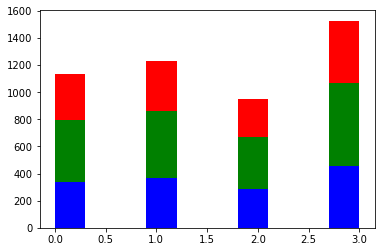

In [7]:
plt.hist(y, color = 'red')
plt.hist(y_train, color = 'green')
plt.hist(y_test, color = 'blue')
pass

### Пункт 3
На этапе предобработки данных сделайте подстановку пропусков методом KnnImputer (neighbors=5) с сохранением бинарных признаков о том, какие переменные были проимпутированы. Преобразования категориальных переменных с помощью WOE, Target encoding, Threshold encoding и других методов, а также преобразование числовых переменных (для получения более симметричных распределений с помощью log или Box-Cox) приветствуется, но не обязательно.

df_2 = df.copy()
# Удаляем символы $ и , с помощью str.replace()
df_2['TargetD'] = df_2['TargetD'].str.replace('$', '')
df_2['TargetD'] = df_2['TargetD'].str.replace(',', '')
df_2['GiftAvgLast'] = df_2['GiftAvgLast'].str.replace('$', '')
df_2['GiftAvgLast'] = df_2['GiftAvgLast'].str.replace(',', '')
df_2['GiftAvg36'] = df_2['GiftAvg36'].str.replace('$', '')
df_2['GiftAvg36'] = df_2['GiftAvg36'].str.replace(',', '')
df_2['GiftAvgAll'] = df_2['GiftAvgAll'].str.replace('$', '')
df_2['GiftAvgAll'] = df_2['GiftAvgAll'].str.replace(',', '')
df_2['GiftAvgCard36'] = df_2['GiftAvgCard36'].str.replace('$', '')
df_2['GiftAvgCard36'] = df_2['GiftAvgCard36'].str.replace(',', '')
df_2['DemMedHomeValue'] = df_2['DemMedHomeValue'].str.replace('$', '')
df_2['DemMedHomeValue'] = df_2['DemMedHomeValue'].str.replace(',', '')
df_2['DemMedIncome'] = df_2['DemMedIncome'].str.replace('$', '')
df_2['DemMedIncome'] = df_2['DemMedIncome'].str.replace(',', '')
df_2

df_2.columns[df_2.isna().any()].tolist()

# Подстановка пропусков
df_3 = df_2.copy()
knn_imp = KNNImputer(n_neighbors = 5)
#df_3.TargetD = knn_imp.fit_transform(df_3['TargetD'].values.reshape(-1, 1))
df_3.GiftAvgCard36 = knn_imp.fit_transform(df_3['GiftAvgCard36'].values.reshape(-1, 1))
df_3.DemAge = knn_imp.fit_transform(df_3['DemAge'].values.reshape(-1, 1))
df_3.DemMedIncome = knn_imp.fit_transform(df_3['DemMedIncome'].values.reshape(-1, 1))
df_3


In [10]:
to_impute = []

for i in X_train.columns:
    if X_train[i].isnull().any() or X_test[i].isnull().any():
        to_impute.append(i)

print(to_impute)

['GiftAvgCard36', 'DemAge', 'DemMedIncome']


In [11]:
for i in to_impute:
    X_train[i+"_imputed"] = X_train[i].isna().astype(int)
    X_test[i+"_imputed"] = X_test[i].isna().astype(int)
    
knn_imp = KNNImputer(n_neighbors = 5)   

knn_imp.fit(X_train[to_impute])
X_train[to_impute] = knn_imp.transform(X_train[to_impute])

knn_imp.fit(X_test[to_impute])
X_test[to_impute] = knn_imp.transform(X_test[to_impute])
X_train

,GiftCnt36,GiftCntAll,GiftCntCard36,GiftCntCardAll,GiftAvgLast,GiftAvg36,GiftAvgAll,GiftAvgCard36,GiftTimeLast,GiftTimeFirst,...,StatusCat96NK_N,StatusCat96NK_S,DemGender_F,DemGender_M,DemGender_U,DemHomeOwner_H,DemHomeOwner_U,GiftAvgCard36_imputed,DemAge_imputed,DemMedIncome_imputed
ID,,,,,,,,,,,,,,,,,,,,,
90350,3,6,2,3,20.0,16.67,13.33,15.00,26,65,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0,1,0
128522,10,48,9,27,11.0,10.20,9.06,10.22,17,130,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0,1,1
104891,2,10,1,6,20.0,15.00,12.60,15.00,17,86,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0,0,1
24663,6,14,2,5,17.0,14.83,10.07,14.00,16,81,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,1
157106,4,32,4,19,36.0,28.00,19.31,28.00,20,128,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184496,4,10,3,8,10.0,10.00,9.00,10.00,19,79,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0,0,0
123805,4,12,4,8,10.0,5.25,4.58,5.25,21,76,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0
178334,7,12,3,7,10.0,11.43,9.17,9.67,15,80,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0,0,0


In [ ]:
# Преобразования категориальных переменных
df_2_2 = df_2.copy()
df_2_2 = pd.get_dummies(df_2[['ID', 'StatusCat96NK', 'DemGender', 'DemHomeOwner']])
df_2_2.head()

,ID,StatusCat96NK_A,StatusCat96NK_E,StatusCat96NK_F,StatusCat96NK_L,StatusCat96NK_N,StatusCat96NK_S,DemGender_F,DemGender_M,DemGender_U,DemHomeOwner_H,DemHomeOwner_U
0,14974,1,0,0,0,0,0,1,0,0,0,1
1,6294,1,0,0,0,0,0,1,0,0,0,1
2,46110,0,0,0,0,0,1,0,1,0,0,1
3,185937,0,1,0,0,0,0,0,1,0,0,1
4,29637,0,0,1,0,0,0,0,1,0,0,1


In [ ]:
df_2_1 = df_2.drop(['ID', 'StatusCat96NK', 'DemGender', 'DemHomeOwner'], axis=1)
df_2_1

,TargetB,TargetD,GiftCnt36,GiftCntAll,GiftCntCard36,GiftCntCardAll,GiftAvgLast,GiftAvg36,GiftAvgAll,GiftAvgCard36,...,PromCnt36,PromCntAll,PromCntCard12,PromCntCard36,PromCntCardAll,StatusCatStarAll,DemAge,DemMedHomeValue,DemPctVeterans,DemMedIncome
0,0,15.624344,2,4,1,3,17.00,13.50,9.25,17.000000,...,17,26,3,8,13,0,59.150845,0,0,53513.457361
1,0,15.624344,1,8,0,3,20.00,20.00,15.88,14.224431,...,35,79,5,5,24,0,67.000000,186800,85,53513.457361
2,1,4.000000,6,41,3,20,6.00,5.17,3.73,5.000000,...,23,51,5,11,22,1,59.150845,87600,36,38750.000000
3,1,10.000000,3,12,3,8,10.00,8.67,8.50,8.670000,...,22,44,2,6,16,1,59.150845,139200,27,38942.000000
4,0,15.624344,1,1,1,1,20.00,20.00,20.00,20.000000,...,15,13,4,7,6,0,53.000000,168100,37,71509.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9681,1,25.000000,2,2,2,2,10.00,15.00,15.00,15.000000,...,29,27,8,12,11,0,59.150845,68200,38,45909.000000
9682,0,15.624344,3,4,1,1,10.00,13.33,11.50,10.000000,...,29,29,6,15,13,0,59.150845,71900,35,50530.000000
9683,1,10.000000,9,14,5,7,10.00,8.78,7.71,8.800000,...,35,46,6,17,18,1,71.000000,115700,32,53513.457361
9684,0,15.624344,2,7,0,1,5.00,12.50,7.43,14.224431,...,34,42,6,6,16,0,59.150845,106300,32,62717.000000


In [ ]:
df_2_3 = pd.concat([df_2_1, df_2_2], axis = 1)
df_2_3.head()

,TargetB,TargetD,GiftCnt36,GiftCntAll,GiftCntCard36,GiftCntCardAll,GiftAvgLast,GiftAvg36,GiftAvgAll,GiftAvgCard36,...,StatusCat96NK_E,StatusCat96NK_F,StatusCat96NK_L,StatusCat96NK_N,StatusCat96NK_S,DemGender_F,DemGender_M,DemGender_U,DemHomeOwner_H,DemHomeOwner_U
0,0,15.624344,2,4,1,3,17.00,13.50,9.25,17.000000,...,0,0,0,0,0,1,0,0,0,1
1,0,15.624344,1,8,0,3,20.00,20.00,15.88,14.224431,...,0,0,0,0,0,1,0,0,0,1
2,1,4.000000,6,41,3,20,6.00,5.17,3.73,5.000000,...,0,0,0,0,1,0,1,0,0,1
3,1,10.000000,3,12,3,8,10.00,8.67,8.50,8.670000,...,1,0,0,0,0,0,1,0,0,1
4,0,15.624344,1,1,1,1,20.00,20.00,20.00,20.000000,...,0,1,0,0,0,0,1,0,0,1


/Users/manya/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

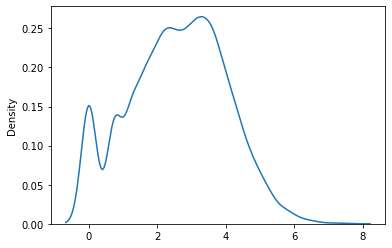

In [ ]:
# Преобразование числовых переменных
transformed_data, best_lambda = boxcox(df_2_3.GiftCntAll) 
sns.distplot (transformed_data, hist = False, kde = True)

transformed_data, best_lambda = boxcox(df_2_3.GiftTimeLast) 
sns.distplot (transformed_data, hist = False, kde = True)

transformed_data, best_lambda = boxcox(df_2_3.GiftTimeFirst) 
sns.distplot (transformed_data, hist = False, kde = True)

transformed_data, best_lambda = boxcox(df_2_3.PromCnt12) 
sns.distplot (transformed_data, hist = False, kde = True)

transformed_data, best_lambda = boxcox(df_2_3.PromCnt36) 
sns.distplot (transformed_data, hist = False, kde = True)

transformed_data, best_lambda = boxcox(df_2_3.PromCntAll) 
sns.distplot (transformed_data, hist = False, kde = True)

transformed_data, best_lambda = boxcox(df_2_3.PromCntCard36) 
sns.distplot (transformed_data, hist = False, kde = True)

transformed_data, best_lambda = boxcox(df_2_3.PromCntCardAll) 
sns.distplot (transformed_data, hist = False, kde = True)

df_2_3.columns

### Пункт 4
Произведите отбор важных переменных с помощью линейного регрессионного метода Backward OLS, перебрав все возможные сложности моделей в рамках вашего метода и выбрав лучшую по кросс-валидации c 5 блоками и MSE в качестве критерия. В пошаговых регрессионных методах для остановки и выбора следующего шага используйте R-квадрат, p- value или AIC на ваше усмотрение. Постройте график зависимости CV-MSE от сложности (число переменных или число компонент в модели), график трассы стандартизованных коэффициентов от сложности. Вертикальной линией на этих графиках обозначьте лучшую по CV сложность модели.

In [41]:
def backward_regression(X, y, threshold_out = 0.05, verbose=True):
    included = list(X.columns)
    while True:
        changed = False
        model = sm.OLS(y.astype(float), sm.add_constant(pd.DataFrame(X[included].astype(float)))).fit()
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop  with p-value '.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [ ]:
backward_regression(X_train, y_train)


Drop  with p-value 
Drop  with p-value 
Drop  with p-value 
Drop  with p-value 
Drop  with p-value 
Drop  with p-value 
Drop  with p-value 
Drop  with p-value 
Drop  with p-value 
Drop  with p-value 
Drop  with p-value 
Drop  with p-value 
Drop  with p-value 
Drop  with p-value 
Drop  with p-value 
Drop  with p-value 
Drop  with p-value 
Drop  with p-value 
Drop  with p-value 
Drop  with p-value 
Drop  with p-value 
Drop  with p-value 
Drop  with p-value 
Drop  with p-value 


['StatusCat96NK_E',
 'GiftTimeFirst',
 'DemMedHomeValue',
 'GiftTimeLast',
 'StatusCatStarAll',
 'GiftAvgLast',
 'TargetD',
 'GiftCnt36',
 'PromCntCardAll',
 'PromCntCard36']

Обратный выбор начинается со всех функций, содержащихся в наборе данных. Затем он запускает модель и вычисляет значение p, связанное с t-тестом или F-тестом модели для каждой функции. Элемент с наибольшим незначительным значением p будет удален из модели, и процесс начнется снова. Это продолжается до тех пор, пока все элементы с незначительными значениями p не будут удалены из модели.

In [48]:
included = backward_regression(X_train, y_train)
model =  sm.OLS(y.astype(float), sm.add_constant(pd.DataFrame(X[included].astype(float)))).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                TargetB   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     39.23
Date:                Fri, 12 May 2023   Prob (F-statistic):           1.69e-76
Time:                        10:41:54   Log-Likelihood:                -29140.
No. Observations:                9686   AIC:                         5.830e+04
Df Residuals:                    9675   BIC:                         5.838e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.2572      0.322  

<AxesSubplot:>

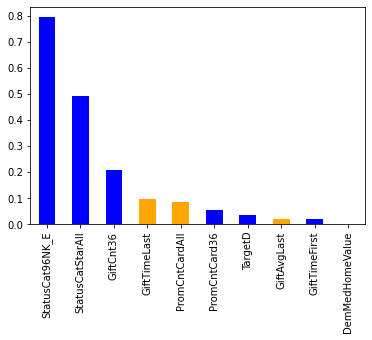

In [176]:
data = model.params.drop('const')
data.sort_values(key=lambda x : abs(x), ascending=False, inplace=True)
colors = ['blue' if value > 0 else 'orange' for value in data.values]
data.abs().plot.bar(color=colors)

### Пункт 5
Для лучшей выбранной сложности линейной модели с помощью бутстреппинга (100 бутстреп выборок размера 25% от исходной) постройте гистограммы (или kde аппроксимацию) распределения константы смещения в полученном регрессионном уравнении (константы b если регрессии y=ax+b) с указанием на графике среднего значения и 95% интервала. Аналогично оцените OOB ошибку MSE. Как она соотносится с лучшей кросс-валидационной ошибкой и ошибкой на проверочной части выборки?

In [ ]:
# Получаем набор данных X и Y, где X - матрица признаков, а Y - вектор целевой переменной
X, Y = X_train[included], y_train

n_iterations = 100
n_size = round(len(Y) * 0.25)

# Сгенерировать несколько выборок методом бутстрэпа
bootstrapped_coef = []
lower_bound = []
upper_bound = []
for i in range(n_iterations):
   #  Сгенерировать новую выборку
    sample_X, sample_Y = resample(X, Y, n_samples=n_size)
    
   #  Построить регрессионную модель
    model = LinearRegression().fit(sample_X, sample_Y)
    
   #  Получить значение константы смещения
    coef = model.intercept_
    lower_bound.append(np.percentile(coef, 2.5))
    upper_bound.append(np.percentile(coef, 97.5))
    bootstrapped_coef.append(coef)

# Вычисляем среднее значение и 95%-ный доверительный интервал для распределения константы смещения
mean_coef = np.mean(bootstrapped_coef)
#lower_bound = np.percentile(bootstrapped_coef, 2.5)
#upper_bound = np.percentile(bootstrapped_coef, 97.5)

# Построить гистограмму распределения константы смещения
plt.hist(bootstrapped_coef, bins=20, alpha=0.5)
plt.plot([mean_coef, mean_coef], [0, 1], linestyle = 'dotted', color="red")
plt.errorbar(ind, bootstrapped_coef[ind], xerr=0.5, yerr=[bootstrapped_coef[ind] - lower_bound[ind], upper_bound[ind] - bootstrapped_coef[ind]], linestyle='')
plt.xlabel('Значение константы смещения')
plt.ylabel('Частота')
plt.title('Распределение константы смещения в модели')
plt.show()

print("Среднее значение константы смещения:", mean_coef)
print("95%-ный доверительный интервал для константы смещения:", lower_bound, "-", upper_bound)


In [ ]:
# 6
from sklearn.neural_network import MLPRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

# Получаем набор данных X и y, где X - матрица признаков, а y - вектор целевой переменной
X, y = X_train[included], y_train

# Определяем набор значений метапараметров
param_grid = {
    'hidden_layer_sizes': [(50, 50), (100, 100), (150, 150)],
    'activation': ['relu'],
    'alpha': [0.001, 0.01, 0.1, 1],
}

# Создаем экземпляр MLPRegressor
mlp_regressor = MLPRegressor(random_state=42)

# Создаем экземпляр HalvingGridSearchCV
grid_search = HalvingGridSearchCV(mlp_regressor, param_grid, cv=5, factor=2, resource='n_samples')

# Обучаем модель на данных
grid_search.fit(X, y)

# Выводим лучшие параметры и значение метрики качества (R2-score)
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

In [ ]:
# Получаем набор данных X и y, где X - матрица признаков, а y - вектор целевой переменной
X, y = X_train[included], y_train

# Определяем диапазон значений для метапараметров и количество повторов
hidden_layer_sizes = [(50, 50), (100, 100), (150, 150)]
alphas = [0.001, 0.01, 0.1, 1]
n_repeats = 5

# Создаем экземпляр MLPRegressor
mlp_regressor = MLPRegressor(random_state=42)

# Создаем экземпляр HalvingGridSearchCV
grid_search = HalvingGridSearchCV(
    mlp_regressor,
    param_grid={"hidden_layer_sizes": hidden_layer_sizes, "alpha": alphas},
    cv=5,
    factor=2,
    resource="n_samples",
    min_resources="exhaust",
    #n_initial_parameters="exhaust",
    aggressive_elimination=True,
    n_jobs=-1,
    verbose=1,
)

# Обучаем модель на данных
grid_search.fit(X, y)

# Извлекаем информацию о решетке
results = grid_search.cv_results_

# Получаем массивы значений метапараметров
alphas = results["param_alpha"].data.astype(float)
layer_sizes = results["param_hidden_layer_sizes"].tolist()

layer_sizes_2 = []
for i in range(len(layer_sizes)):
    layer_sizes_2.append(layer_sizes[i][0])

# Получаем массивы значений среднего и стандартного отклонения метрики качества
mean_scores = results["mean_test_score"]
std_scores = results["std_test_score"]

# Вычисляем логарифм по основанию 10 от метрики качества
log_scores = np.log10(mean_scores)

# Вычисляем размер точек по числу повторов
sizes = results["n_resources"].astype(float)

# Отображаем точки, цветом указывая метрику качества, а размером точек - число повторов
plt.scatter(alphas, layer_sizes_2, c=log_scores, s=sizes, cmap="YlOrRd", edgecolors="black")
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("hidden_layer_sizes")
plt.title("Grid Search Halving for MLPRegressor")
plt.colorbar(label="log10(R2-score)")
plt.show()
